In [1]:
'''
author: Yike Xie
data: Oct/2023
content: kde plots for the manuscript
'''

'\nauthor: Yike Xie\ndata: Oct/2023\ncontent: kde plots for the manuscript\n'

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [2]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

def plot_bins(adata, fea, bin_n, gene, cmap, filetype, path=False, rho=False, ):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = round(exp.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < exp.shape[0]]
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 3])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median() # average expression
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/(max(med) + 0.001) for i in med] # avoid average expression is 0
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, 
                  edgecolor='white', linewidth=1, size=3)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')
    
    if rho is not False:
        ax.text(0.5, ax.get_yticks()[-4], r'$\rho$={}'.format(round(rho, 2)))

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}


In [3]:
def kdes(corr, fea, path=False):
    from matplotlib.lines import Line2D
    rcParams['pdf.fonttype'] = 42

    fig, ax = plt.subplots(figsize=[3,3])
    cs = sns.color_palette('tab10', 3)

    handles = []
    labels = []
    for i, c in zip([0, 10, 50], cs):
        sns.kdeplot(data=corr[corr['Number'] > i], x=fea, lw=2, 
                    ax=ax, c=c)
        handles.append(Line2D([], [], color=c, lw=2))
        labels.append('≥{} cells'.format(str(i)))

    ax.legend(handles=handles, labels=labels, loc='upper left', 
              bbox_to_anchor=[1, 1], title='Genes expressed by')
    ax.set_xlabel(r'$\rho$ [{} vs. Exp]'.format(fea.capitalize()))
    ax.set_ylabel('Density')

    if path is not False:
        fig.savefig(path + '{}_kde_0_10_50.pdf'.format(fea), dpi=150, bbox_inches='tight')
        
def kde_fea(corr, n, fea, genes, colors, path=False):
    
    rcParams['pdf.fonttype'] = 42
    fig, ax = plt.subplots(figsize=[2.5,2.5])
    sns.kdeplot(data=corr[corr['Number'] > n], x=fea, lw=2, 
                ax=ax, c='gray')
    ax.set_title('Genes expressed by ≥{} cells'.format(str(n)))
    ax.set_xlabel(r'$\rho$ [{} vs. Exp]'.format(fea.capitalize()))
    ax.set_ylabel('Density')
    ax.grid(lw=1, ls='--', zorder=-5, alpha=0.5)

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    points = list(zip(x, y))
    t_dic = dict(points)

    x_trues = [corr.loc[gene][fea] for gene in genes]
    x_points = []
    y_points = []
    for x in x_trues:
        x_point = find_nearest(np.array(list(t_dic.keys())), x)
        x_points.append(x_point)
        y_points.append(t_dic[x_point])

    sns.scatterplot(x = x_points,
                    y = y_points, c=colors, s=50)

    for gene, x, y, c in zip(genes, x_points, y_points, colors):
        ax.annotate(gene, xy=(x, y), xytext=(x, y+0.8), arrowprops=dict(arrowstyle="<-"), 
                    va='center', ha='center', color=c)

    if path is not False:
        fig.savefig(path + '{}_kde.pdf'.format(fea), dpi=150, bbox_inches='tight')

    return {'fig': fig, 'ax': ax}

In [4]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/combine_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/combine_gene.h5ad'
adata = sig_dataset(feas_fn, data_fn)

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/'

# add average optical intensity to adata
df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
for i in df.index:
    df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]
    
for col in df.columns:
    adata.obs['{}_{}'.format(col[0], col[1])] = df.loc[adata.obs_names][col]
    
adata.obs['C4_C2'] = df[df.columns[3]] / df[df.columns[1]]

load features
load dataset
filter genes


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Add features to adata


In [9]:
adata.obs.index.str.startswith('1-').sum()

39

In [10]:
adata.obs.index.str.startswith('2-').sum()

54

## focus following analyses on cells with low percentage of mitochondrial reads

In [6]:
## divide live and dead cells according to the fraction o mitochondrial reads
live_cells = adata.obs[adata.obs['pct_counts_mt'] < 25].index
dead_cells = adata.obs[adata.obs['pct_counts_mt'] > 25].index

# create dataset only having cells with low percentage of mitochondrial reads
adata_live = adata[live_cells, :]

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [14]:
def plot_bins(adata, fea, bin_n, gene, cmap, xlabel, filetype, path=False, rho=False, ):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = round(exp.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < exp.shape[0]]
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 2.5])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median() # average expression
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/(max(med) + 0.001) for i in med] # avoid average expression is 0
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, 
                  edgecolor='white', linewidth=1, size=3)

    bins = np.array_split(adata.obs[fea].sort_values().array, 8)
    round_n = [0, 2]['.' in str(bins[0])]
#     round_n = 0
    xticklabels = [f'{f"%.{round_n}f" % (i.min())}-{f"%.{round_n}f" % (i.max())}' for i in bins]
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.set_xlabel(xlabel)
#     ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')
    
    if rho is not False:
        ax.text(0.5, ax.get_yticks()[-4], r'$\rho$={}'.format(round(rho, 2)))

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}

In [8]:
save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/'
corr = pd.read_csv(save_figures + 'spectra_gene_correlation_live_cells.tsv', sep='\t', index_col=0).fillna(0)

In [15]:
import gseapy as gp
from gseapy.plot import barplot

def pathway_df(gene_list):    
    pthw = gp.enrichr(gene_list=gene_list,
                         gene_sets=['GO_Biological_Process_2021'],
                         description='pathway',
                         cutoff = False).res2d

    pthw_plot = pthw[:10]
    pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
    
    return pthw_plot

In [16]:
n = 300
neg_list = corr[corr['Number'] >= 10]['343_451'].sort_values()[:n].index.tolist()
pos_list = corr[corr['Number'] >= 10]['343_451'].sort_values()[-n:].index.tolist()

gene_list = neg_list + pos_list

# pathway analysis
pt_df_n = pathway_df(neg_list)
pt_df_p = pathway_df(pos_list)
pthw_plot = pd.concat([pt_df_p[:5], pt_df_n[:5]])

pt_df_n.to_csv(save_figures + 'pathways_negative_correlate_C4.tsv', sep='\t')
pt_df_p.to_csv(save_figures + 'pathways_positive_correlate_C4.tsv', sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-10-06 17:54:32,248 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = False
<ipython-input-15-b81eca27947c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.resul

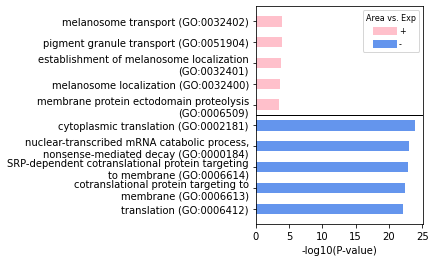

In [18]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=[3, 4])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 8

ax.barh(range(10), pthw_plot['-log10(P-value)'][::-1], 
        height=0.5, color=['cornflowerblue'] * 5 + ['pink'] * 5)
ax.set_yticks(range(10))
yticklabels = []
for i in pthw_plot['Term'][::-1]:
    if len(i.split(' ')) > 4:
        yticklabels.append(' '.join(i.split(' ')[:4]) + '\n' + ' '.join(i.split(' ')[4:]))
    else:
        yticklabels.append(i)
ax.set_yticklabels(yticklabels)

ax.axhline(4.5, c='k', lw=1)
handles = [Line2D([], [], lw=8, c='pink'),
           Line2D([], [], lw=8, c='cornflowerblue')]
ax.legend(handles=handles, labels=['+', '-'], title='Area vs. Exp', loc='best', fontsize=8)

ax.set_xlabel('-log10(P-value)')
fig.savefig(save_figures + '300_genes_C4_pathway.pdf', dpi=150, bbox_inches='tight')
# Microtubules are cytoskeletal filaments central to a wide range of essential cellular 
    # functions in eukaryotic cells.
#

In [30]:
corr.loc[pt_df_n.iloc[0]['Genes'].split(';')][['343_451', 'Frac', 'Number']]
# RPS5
# LDHA: The protein encoded by this gene catalyzes the conversion of L-lactate and NAD to pyruvate and NADH in the final step of anaerobic glycolysis.
#  Interconverts simultaneously and stereospecifically pyruvate and lactate with concomitant interconversion of NADH and NAD(+)
# GAPDH: The product of this gene catalyzes an important energy-yielding step in carbohydrate metabolism, the reversible oxidative phosphorylation of glyceraldehyde-3-phosphate in the presence of inorganic phosphate and nicotinamide adenine dinucleotide (NAD). 

,343_451,Frac,Number
gene_name,,,
RPL5,-0.183332,98.319328,117
RPL32,-0.125053,99.159664,118
RPL12,-0.174142,99.159664,118
RPLP0,-0.115981,100.000000,119
RPL6,-0.207044,98.319328,117
GSPT1,-0.214025,92.436975,110
RPS15,-0.216899,100.000000,119
RPL7A,-0.163933,98.319328,117
RPS15A,-0.117773,94.117647,112


In [44]:
a = 'SCARB2,CLU,HSPA5,LAMP2,OXA1L,RAD21,TPR,TMED10,RER1,TRAM1,SEC61A1,AKIRIN2,CCDC47,RTN4,TOR1AIP2,ATP6AP1,HSPB1,SAR1A,RPN2,PSAP'
corr.loc[a.split(',')][['343_451', 'Frac', 'Number']]
# NDUFA2: The protein encoded by this gene is a core subunit of the mitochondrial membrane respiratory chain NADH dehydrogenase (complex I).
# MYO5A: This gene is one of three myosin V heavy-chain genes, belonging to the myosin gene superfamily. Myosin V is a class of actin-based motor proteins involved in cytoplasmic vesicle transport and anchorage, spindle-pole alignment and mRNA translocation. 

,343_451,Frac,Number
gene_name,,,
SCARB2,0.290643,75.630252,90
CLU,0.255211,87.394958,104
HSPA5,0.296026,89.075630,106
LAMP2,0.279331,84.873950,101
OXA1L,0.327198,82.352941,98
RAD21,0.351984,78.151261,93
TPR,0.378476,78.991597,94
TMED10,0.321423,89.075630,106
RER1,0.247819,84.033613,100


In [56]:
OXPHOS_fn = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/OxidativePhosphorylationGenes.xlsx'

OXPHOS_genes = pd.read_excel(OXPHOS_fn)['OXPHOS_genes'].tolist()
OXPHOS_genes = list(set(OXPHOS_genes) & set(corr.index))

## neg: 28 ## pos: 76
OXPHOS_show = corr.loc[OXPHOS_genes][['343_451']].sort_values('343_451')

# source: https://maayanlab.cloud/Enrichr/enrich 
# harmonizome_oxidative+phosphorylation_KEGG+Pathways (126 genes)

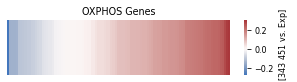

In [112]:
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=[5, 1])
sns.heatmap(OXPHOS_show.T, center=0, cmap='vlag', 
            cbar_kws={'label': r'$\rho$ [{} vs. Exp]'.format('343 451')})

ax.set_xlabel(None)
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_title('OXPHOS Genes')

plt.savefig(save_figures + 'OXPHOS_genes_C4_3.pdf', bbox_inches='tight', dpi=300)
plt.savefig(save_figures + 'OXPHOS_genes_C4_3.png', bbox_inches='tight', dpi=300)

In [291]:
corr.loc[OXPHOS_genes][['343_451', 'Number']].sort_values('343_451')[:50]

,343_451,Number
gene_name,,
ATP5B,-0.273202,119
ATP5F1,-0.145341,114
NDUFAB1,-0.142745,113
ATP5C1,-0.140740,114
NDUFB10,-0.138800,115
UQCRFS1,-0.104620,111
NDUFS5,-0.104088,116
NDUFA8,-0.099989,108
NDUFS8,-0.099574,115


In [302]:
corr[['343_451', 'Number']].sort_values('343_451')[-50:].index

Index(['ANKRD50', 'TPR', 'FBXL15', 'SENP7', 'DDAH1', 'ZNF277', 'RPUSD2',
       'ADCY5', 'ADAM17', 'GNPAT', 'TLN2', 'TRMT2B', 'GON4L', 'TBX2', 'ZBTB4',
       'ITGAV', 'ZSCAN22', 'ADAM9', 'AMFR', 'IFT122', 'HLCS', 'MAN1B1', 'RTN3',
       'DSCAM-AS1', 'GTF2IP1', 'LAPTM4A', 'FNTB', 'SNHG10', 'CCDC132',
       'MMP24-AS1', 'ZRANB3', 'GEMIN8', 'TMEM150C', 'PAAF1', 'MIA3', 'THAP3',
       'SLC22A18', 'NSUN4', 'HIST1H4E', 'MAGT1', 'CASP3', 'HSD17B7', 'SGPL1',
       'OGFOD3', 'ACAA2', 'DUSP18', 'ALCAM', 'PTCD3', 'XYLT2', 'LIPA'],
      dtype='object', name='gene_name')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

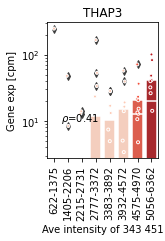

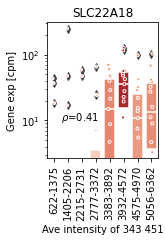

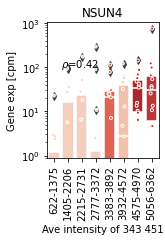

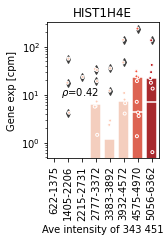

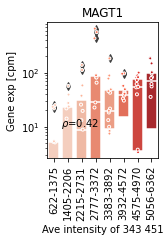

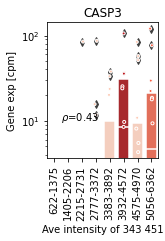

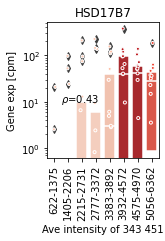

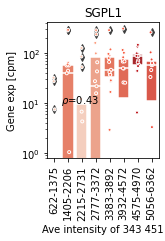

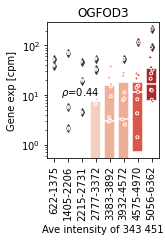

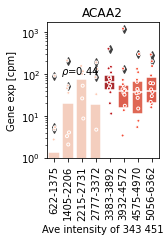

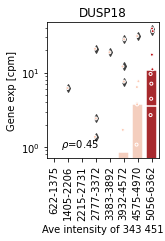

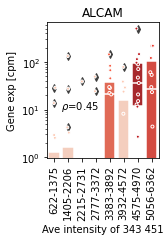

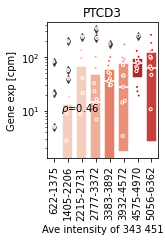

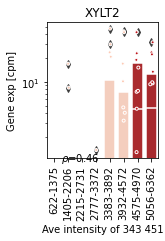

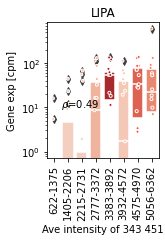

In [303]:
for gene in corr[['343_451', 'Number']].sort_values('343_451')[-15:].index:
    fea = '343_451'
    genes = [gene]
    colors = ['Reds']
    bin_n = 8
    
    rho = corr_C.loc[gene][fea]
    plot_bins(adata_live, fea, bin_n, gene, cmap, 'Ave intensity of 343 451', '.pdf', 
              path=False, rho=rho)

{'fig': <Figure size 180x180 with 1 Axes>,
 'ax': <AxesSubplot: title={'center': 'Genes expressed by ≥10 cells'}, xlabel='$\\rho$ [343_451 vs. Exp]', ylabel='Density'>}

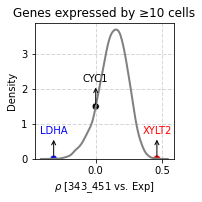

In [307]:
fea = '343_451'
genes = ['LDHA', 'CYC1', 'XYLT2',]
colors = ['blue', 'black', 'red']
n = 10

kde_fea(corr_C, n, fea, genes, colors, path=save_figures_C)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


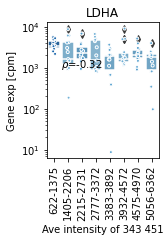

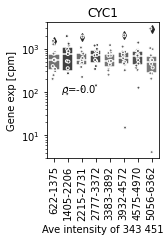

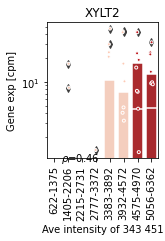

In [308]:
fea = '343_451' # '
genes = ['LDHA', 'CYC1', 'XYLT2'] #  
cmaps = ['Blues','Greys', 'Reds', ] # 
bin_n = 8

for gene, cmap in zip(genes, cmaps):
    rho = corr_C.loc[gene][fea]
    plot_bins(adata_live, fea, bin_n, gene, cmap, 'Ave intensity of 343 451', '.pdf', path=save_figures_C, rho=rho)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


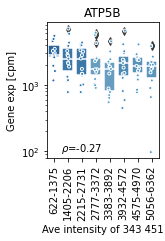

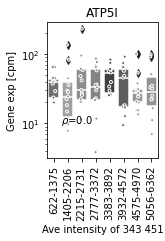

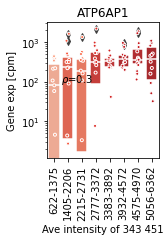

In [309]:
fea = '343_451' # '
genes = ['ATP5B', 'ATP5I', 'ATP6AP1'] #  
cmaps = ['Blues','Greys', 'Reds', ] # 
bin_n = 8

for gene, cmap in zip(genes, cmaps):
    rho = corr_C.loc[gene][fea]
    plot_bins(adata_live, fea, bin_n, gene, cmap, 'Ave intensity of 343 451', '.pdf', path=save_figures_C, rho=rho)

## C4 / C2

In [9]:
save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/'
corr_ratio = pd.read_csv(save_figures + 'correlation_ratio_4_2_live_cells.tsv', sep='\t', index_col=0).fillna(0)

{'fig': <Figure size 180x180 with 1 Axes>,
 'ax': <AxesSubplot: title={'center': 'Genes expressed by ≥10 cells'}, xlabel='$\\rho$ [C4_c2 vs. Exp]', ylabel='Density'>}

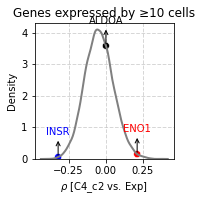

In [11]:
fea = 'C4_C2'
genes = ['INSR', 'ALDOA', 'ENO1',]
colors = ['blue', 'black', 'red']
n = 10

kde_fea(corr_ratio, n, fea, genes, colors, path=save_figures)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


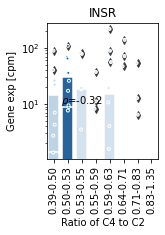

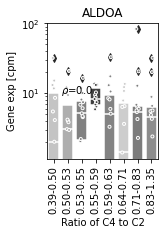

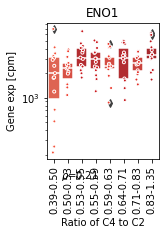

In [15]:
fea = 'C4_C2'
genes = ['INSR', 'ALDOA', 'ENO1',]
cmaps = ['Blues','Greys', 'Reds', ] # 
bin_n = 8

for gene, cmap in zip(genes, cmaps):
    rho = corr_ratio.loc[gene][fea]
    plot_bins(adata_live, fea, bin_n, gene, cmap, 'Ratio of C4 to C2', '.pdf', path=save_figures, rho=rho)

In [130]:
import gseapy as gp
from gseapy.plot import barplot

def pathway_df(gene_list):    
    pthw = gp.enrichr(gene_list=gene_list,
                         gene_sets=['GO_Biological_Process_2021'],
                         description='pathway',
                         cutoff = False).res2d

    pthw_plot = pthw[:10]
    pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
    
    return pthw_plot

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-10-10 20:08:06,060 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = False
<ipython-input-130-b81eca27947c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.resu

Text(0.5, 0, '-log10(P-value)')

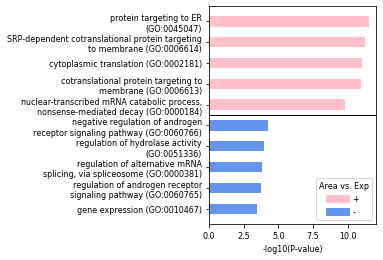

In [276]:
n = 300
neg_list = corr_ratio[corr_ratio['Number'] >= 10]['C4_C2'].sort_values()[:n].index.tolist()
pos_list = corr_ratio[corr_ratio['Number'] >= 10]['C4_C2'].sort_values()[-n:].index.tolist()

gene_list = neg_list + pos_list

# pathway analysis
pt_df_n = pathway_df(neg_list)
pt_df_p = pathway_df(pos_list)
pthw_plot = pd.concat([pt_df_p[:5], pt_df_n[:5]])

# pt_df_n.to_csv(save_figures + 'pathways_negative_corr_ratioelate_C4_C2.tsv', sep='\t')
# pt_df_p.to_csv(save_figures + 'pathways_positive_corr_ratioelate_C4_C2.tsv', sep='\t')

### plotting
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=[3, 4])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 8

ax.barh(range(10), pthw_plot['-log10(P-value)'][::-1], 
        height=0.5, color=['cornflowerblue'] * 5 + ['pink'] * 5)
ax.set_yticks(range(10))
yticklabels = []
for i in pthw_plot['Term'][::-1]:
    if len(i.split(' ')) > 4:
        yticklabels.append(' '.join(i.split(' ')[:4]) + '\n' + ' '.join(i.split(' ')[4:]))
    else:
        yticklabels.append(i)
ax.set_yticklabels(yticklabels)

ax.axhline(4.5, c='k', lw=1)
handles = [Line2D([], [], lw=8, c='pink'),
           Line2D([], [], lw=8, c='cornflowerblue')]
ax.legend(handles=handles, labels=['+', '-'], title='Area vs. Exp', loc='best', fontsize=8)

ax.set_xlabel('-log10(P-value)')
# fig.savefig(save_figures + '300_genes_C4_C2_pathway.pdf', dpi=150, bbox_inches='tight')

In [248]:
pthws = {}
for gene_list, typei in zip([neg_list, pos_list], ['neg', 'pos']):    
    pthw = gp.enrichr(gene_list=gene_list,
                         gene_sets=['GO_Biological_Process_2021'],
                         description='pathway',
                         cutoff = False).res2d
    pthw.to_csv(save_figures + 'C4_C2/' + f'{typei}_pathway_C4_C2.tsv', sep='\t')
    pthws[typei] = pthw

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-10-10 16:44:38,069 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = False
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-10-10 16:44:43,778 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = False


- for positive pathways
19: gluconeogenesis (GO:0006094)
22: hexose biosynthetic process (GO:0019319)
29: positive regulation of ATP biosynthetic process (GO:2001171)
37: positive regulation of ATP metabolic process (GO:1903580)
41: glucose metabolic process (GO:0006006)
56: regulation of ATP biosynthetic process (GO:2001169)

- for negative pathways
28: regulation of glycolytic process (GO:0006110)
42: regulation of glycogen biosynthetic process (GO:0005979)
56: lipid phosphorylation (GO:0046834)
79: positive regulation of glycogen biosynthetic process (GO:0045725)
81: phosphorylation (GO:0016310)

In [249]:
pthw_plot_mtb = pd.concat([pthws['pos'].iloc[[19, 22, 29, 37, 41]], pthws['neg'].iloc[[28, 42, 56, 79, 81]]])
pthw_plot_mtb['-log10(P-value)'] = -np.log10(pthw_plot_mtb['P-value'])

Text(0.5, 0, '-log10(P-value)')

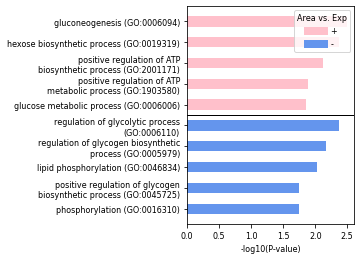

In [252]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=[3, 4])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 8

ax.barh(range(10), pthw_plot_mtb['-log10(P-value)'][::-1], 
        height=0.5, color=['cornflowerblue'] * 5 + ['pink'] * 5)
ax.set_yticks(range(10))
yticklabels = []
for i in pthw_plot_mtb['Term'][::-1]:
    if len(i.split(' ')) > 4:
        yticklabels.append(' '.join(i.split(' ')[:4]) + '\n' + ' '.join(i.split(' ')[4:]))
    else:
        yticklabels.append(i)
ax.set_yticklabels(yticklabels)

ax.axhline(4.5, c='k', lw=1)
handles = [Line2D([], [], lw=8, c='pink'),
           Line2D([], [], lw=8, c='cornflowerblue')]
ax.legend(handles=handles, labels=['+', '-'], title='Area vs. Exp', 
          loc='best', fontsize=8)

ax.set_xlabel('-log10(P-value)')
fig.savefig(save_figures + 'C4_C2/' + 'metabolic_pathways.pdf', dpi=300, bbox_inches='tight')

Hydrolase Regulates NAD+ Metabolites and Modulates Cellular Redox

doi: 10.1074/jbc.M809790200

doi: 10.1128/MCB.00032-12

In some cases the affinity of an ambiguous targeting signal to the different compartments can be changed by modification or binding of other proteins. An example for modification of an ambiguous targeting sequence can be found in the mammalian NADH–cytochrome b(5) reductase (b5R). This protein is localized both to the mitochondrial outer membrane and to the ER membrane. On the ER membrane it participates in different aspects of lipid metabolism via its function as an electron acceptor. On the mitochondrial outer membrane it mediates the regeneration of ascorbate from ascorbate free radical and is involved in transfer of electrons from cytosolic NADH to cytochrome c in the intermembrane space. This protein is translated from a single mRNA to create a single translation product, harboring an N-terminal targeting signal, required for both ER and mitochondrial targeting. This signal contains a moderately hydrophobic stretch of 14 amino acids that is preceded by a myristoylation consensus sequence, which is modified in about half of the molecules. In the absence of myristoylation, the nascent chain is bound to the SRP and is targeted to the ER. Myristoylation of the N-terminus lowers the affinity of the signal for SRP; the nascent chain remains on free polysomes and is imported post-translationally into the mitochondria [30].

https://www.sciencedirect.com/science/article/pii/S0005273610002385

! lipid metabolism

 https://doi.org/10.1016/0014-5793(93)81416-W

In [206]:
# glycolysis (KEGG 2021 Human)
# pentose phosphate pathway (KEGG 2021 Human)
# tricarboxylic acid (TCA) (Tricarboxylic acid (TCA) cycle and respiratory electron transport from BioPlanet_2019)
# oxidative phosphorylation (KEGG 2021 Human)

In [215]:
path_df = pd.read_excel('/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/MetabolicPathways.xlsx',)

In [224]:
path_genes_show = {}
for path in path_df.columns:
    gs = list(set(path_df[path].dropna()) & set(corr_ratio.index))
    gs = corr_ratio.loc[gs][corr_ratio.loc[gs]['Number'] >=10].index
    gs_show = corr_ratio.loc[gs][['C4_C2']].sort_values('C4_C2') 
    path_genes_show[path] = gs_show
    
    print(f'Pathway {path} has {str(len(gs))} genes')
    p_n = (gs_show['C4_C2'] > 0).sum()
    print(f'{str(p_n)} positive correlated with C4_C2 and gene exp')
    print(f'{str(len(gs) - p_n)} negative correlated with C4_C2 and gene exp')
    print('____________________________________________')

Pathway OXPHOS has 104 genes
33 positive correlated with C4_C2 and gene exp
71 negative correlated with C4_C2 and gene exp
____________________________________________
Pathway Glycolysis has 40 genes
19 positive correlated with C4_C2 and gene exp
21 negative correlated with C4_C2 and gene exp
____________________________________________
Pathway Pentose phosphate has 22 genes
7 positive correlated with C4_C2 and gene exp
15 negative correlated with C4_C2 and gene exp
____________________________________________
Pathway TCA cycle has 110 genes
38 positive correlated with C4_C2 and gene exp
72 negative correlated with C4_C2 and gene exp
____________________________________________


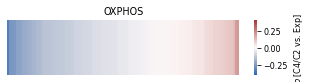

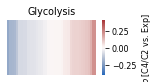

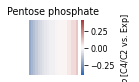

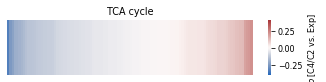

In [239]:
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 8

for path in path_df.columns:
    gs_number = path_genes_show[path].shape[0]
    fig, ax = plt.subplots(figsize=[gs_number/20, 1])
    sns.heatmap(path_genes_show[path].T, center=0, cmap='vlag', vmin = -0.4, vmax=0.4, 
                cbar_kws={'label': r'$\rho$ [{} vs. Exp]'.format('C4/C2')})

    ax.set_xlabel(None)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_title(path)

    plt.savefig(save_figures + f'{path}_C4_C2.pdf', 
                bbox_inches='tight', dpi=300)
    plt.savefig(save_figures + f'{path}_C4_C2.pdf',
                bbox_inches='tight', dpi=300)

### with NADH/NAD+ ratio

Our studies suggest that the fluorescence lifetime of both the free and the protein-bound components of NADH and the ratio of free to protein-bound NADH is related to changes in the NADH/NAD+ ratio.

Biochemical estimation of NADH concentration is a useful method for monitoring cellular metabolism, because the NADH/NAD+ reduction-oxidation pair is crucial for electron transfer in the mitochondrial electron chain. 

https://doi.org/10.1158/0008-5472.CAN-04-3922

A shift toward the higher free NADH is indicative of a more glycolytic metabolism and a reverse shift is indicative of more oxidative phosphorylation.
 
Free and protein bound NADH have been used often to noninvasively predict or determine the changes in cellular metabolism

the ratio of NAD+/NADH can be correlated to free and bound NADH and these two NADH species have very different lifetimes

https://doi.org/10.1002/jbio.201900156


In [280]:
# x = corr_C['343_451']
x = corr_C['343_414']
y = corr_ratio['C4_C2'].loc[x.index]

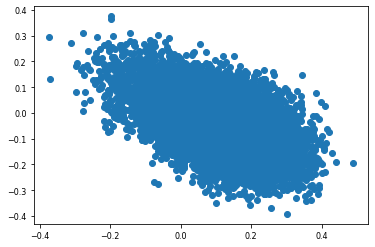

In [281]:
plt.scatter(x, y)